In [1]:
import sys
import os
import pandas as pd
import joblib

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, train_val_split, get_dimensions, scale, metrics_c, get_device, \
    plot_history, load_best_params, plot_mlp_comparison, d_types_methods, get_color_map, encode_labels, get_model_path

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, activation_funcs

## Settings

In [5]:
# Data Path
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

# Model Export Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
os.makedirs(path_models, exist_ok=True)

In [6]:
# Targets
target = "HistoricalPeriod"

In [7]:
# Current Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [8]:
# Training Loss Function and Extra Metrics
criterion = nn.CrossEntropyLoss()
metrics = metrics_c

In [9]:
feature_colors = get_color_map(feature_types + tuple(" + ".join(fts) for fts in feature_type_combos), "Set2")

## Data

### Read Features and Targets

In [10]:
X = read_features(path, f_type="tensors")
y = read_targets(path, [target])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


### Encode Target Labels

In [11]:
y, target_enc, le = encode_labels(y, target)

# Export encoder
joblib.dump(le, "y_encoder.pkl")

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


['y_encoder.pkl']

In [12]:
y = {
    subset: torch.tensor(_y[target_enc].values, dtype=torch.long, device=device)
    for subset, _y in y.items()
}

### Train-Validation Split


In [13]:
X, y = train_val_split(X, y)

### Dimensions

In [14]:
X_dim, y_dim = get_dimensions(X, y, le)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [15]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Best Params from Tuning

In [16]:
# Load Saved Best Params
path_params = "best_params.json"
best_params = load_best_params(path_params)

## Text Input MLP Model

### Compare & Choose Model

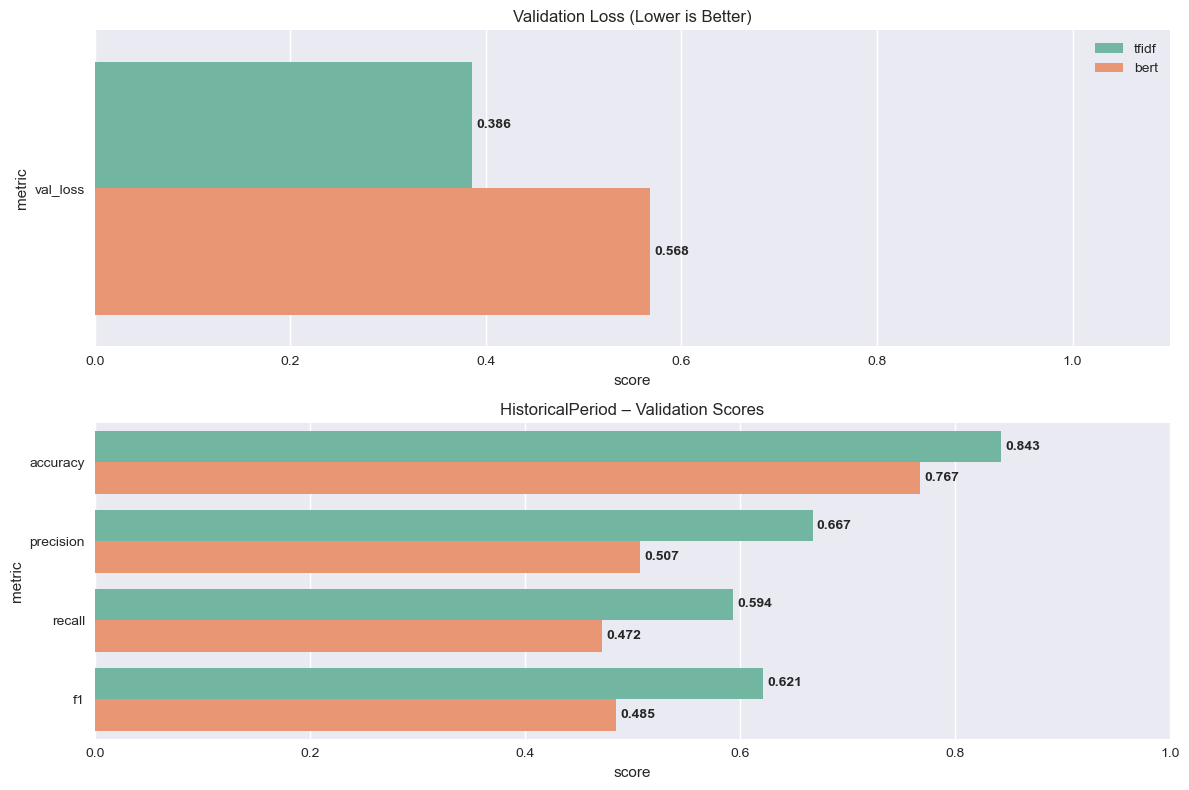

In [17]:
plot_mlp_comparison(
    {ft: best_params[ft] for ft in d_types_methods["text"]},
    {ft: feature_colors[ft] for ft in d_types_methods["text"]},
    [target]
)

### Build, Train & Save Model

activation                 relu
blocks                        3
dropout                     0.2
hidden_size                 512
hidden_size_pattern    constant
lr                         0.01
Name: value, dtype: object
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 512]                  154,112                   154,112
│    │    └─ReLU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3             

            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1153.02it/s, loss=1.0414]


** Early stop | ran: 14/50 epochs | final: epoch 04 | train_loss: 0.3840, val_loss: 0.4817, accuracy: [0.76], precision: [0.38], recall: [0.39], f1: [0.38], 


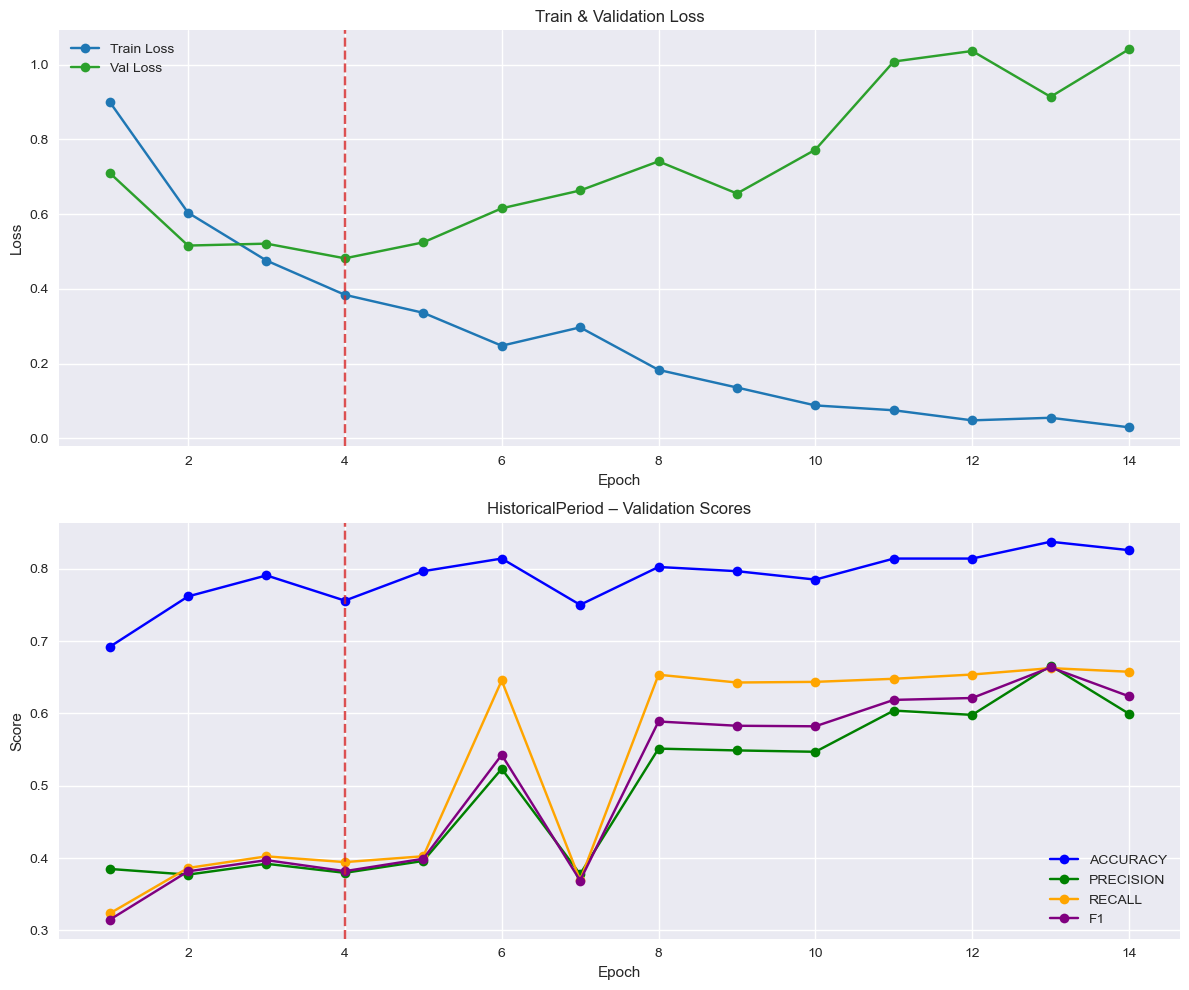

In [18]:
ft = "tfidf"
params = best_params[ft]["params"]
print(pd.Series(params, name="value"))

# Build Model
model = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Train Model
model, history = train(
    model,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    lr=params["lr"],
)

plot_history(history, [target])

# Save Model
torch.save(model.state_dict(), get_model_path(path_models, ft))

## Image Input MLP Model

### Compare & Choose Model

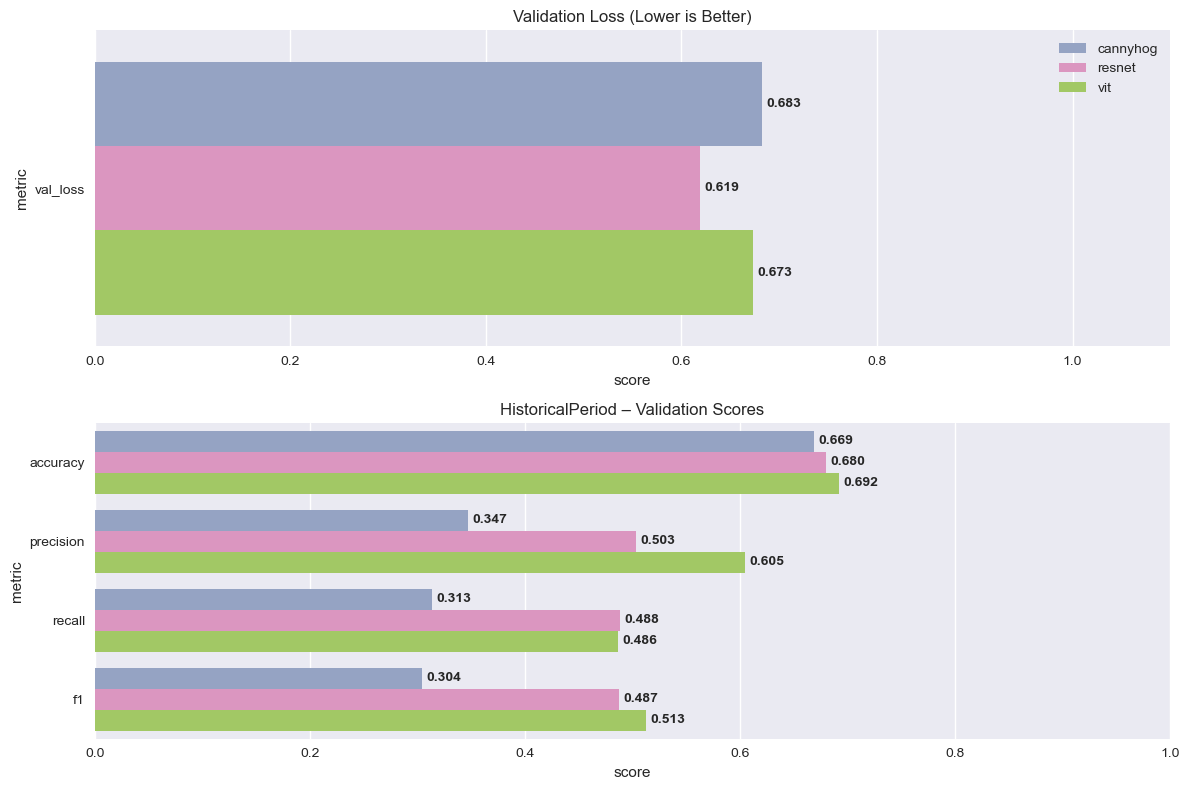

In [19]:
plot_mlp_comparison(
    {ft: best_params[ft] for ft in d_types_methods["image"]},
    {ft: feature_colors[ft] for ft in d_types_methods["image"]},
    [target]
)

### Build, Train & Save Model

activation                 gelu
blocks                        2
dropout                     0.2
hidden_size                 512
hidden_size_pattern    constant
lr                       0.0005
Name: value, dtype: object
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 512]                  393,728                   393,728
│    │    └─GELU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3             

            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 898.65it/s, loss=0.7961]


** Early stop | ran: 18/50 epochs | final: epoch 08 | train_loss: 0.6126, val_loss: 0.7026, accuracy: [0.67], precision: [0.59], recall: [0.40], f1: [0.43], 


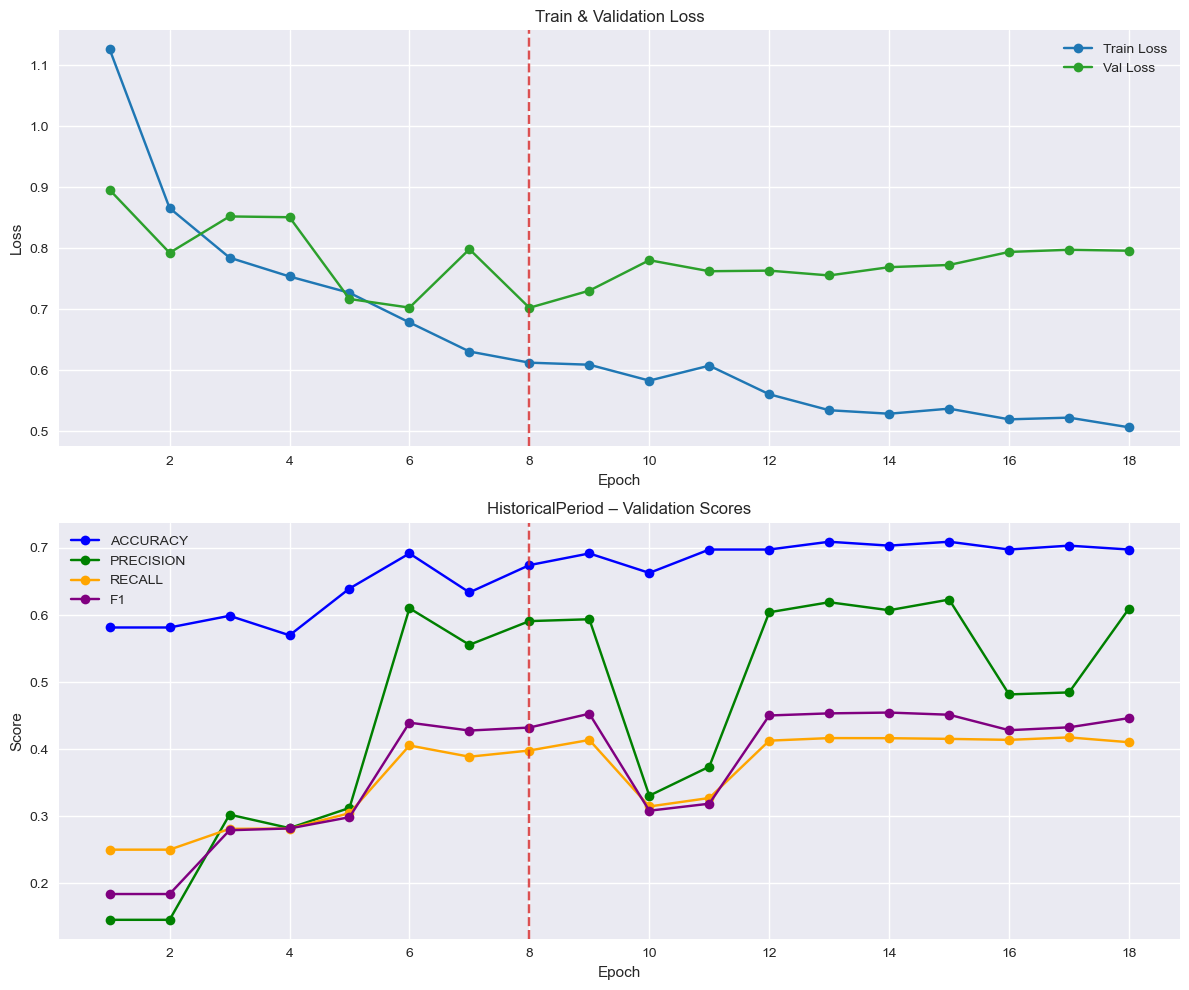

In [20]:
ft = "vit"
params = best_params[ft]["params"]
print(pd.Series(params, name="value"))

# Build Model
model = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Train Model
model, history = train(
    model,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    lr=params["lr"],
)

plot_history(history, [target])

# Save Model
torch.save(model.state_dict(), get_model_path(path_models, ft))

## Text + Image Combo Input MLP Model

### Compare & Choose Model

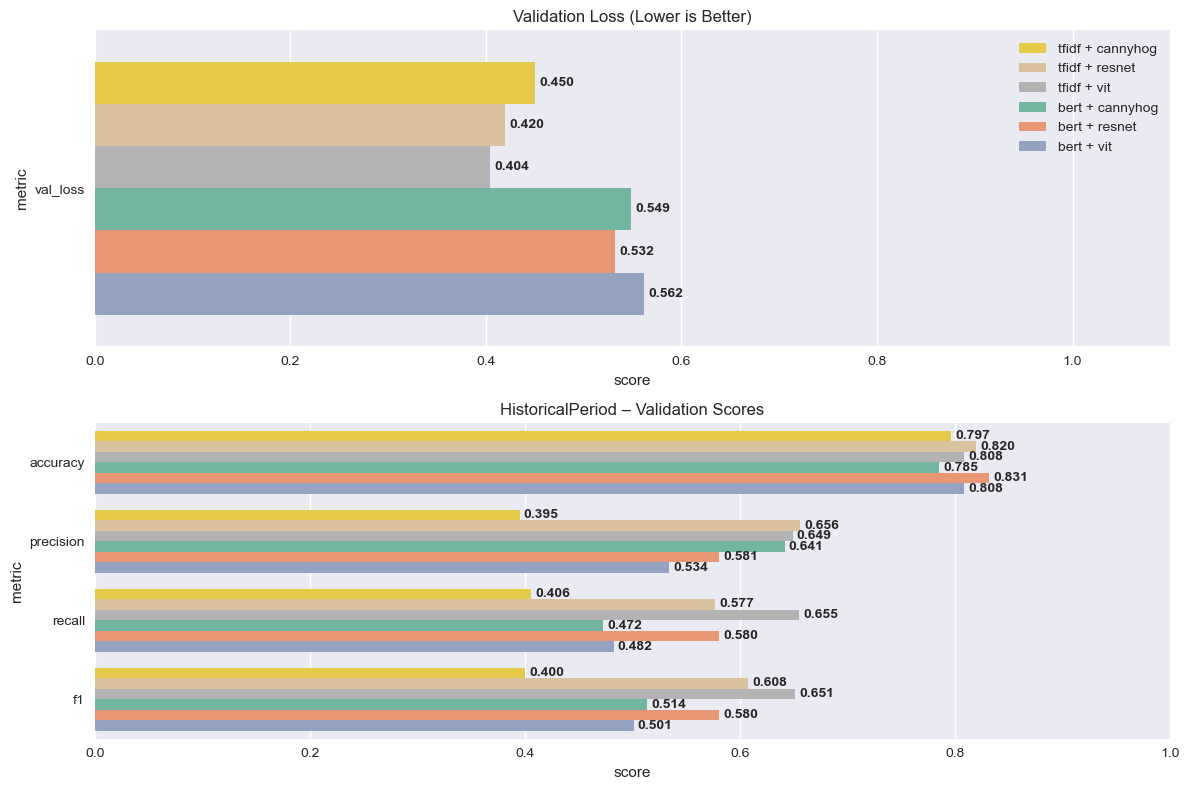

In [21]:
plot_mlp_comparison(
    {" + ".join(fts): best_params[" + ".join(fts)] for fts in feature_type_combos},
    {" + ".join(fts): feature_colors[" + ".join(fts)] for fts in feature_type_combos},
    [target]
)

### Build, Train & Save Model

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 128]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 128]                  38,528                    38,528
│    │    └─ReLU: 3-2                    [1, 128]                  [1, 128]                  --                        --
│    │    └─Dropout: 3-3                 [1, 128]                  [1, 128]                  --                        --
│    └─Sequential: 2-2                   [1, 768]                  [1, 128]                  --                        --
│    │    └─L

            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1189.20it/s, loss=0.7935]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.3103, val_loss: 0.4615, accuracy: [0.81], precision: [0.65], recall: [0.57], f1: [0.60], 


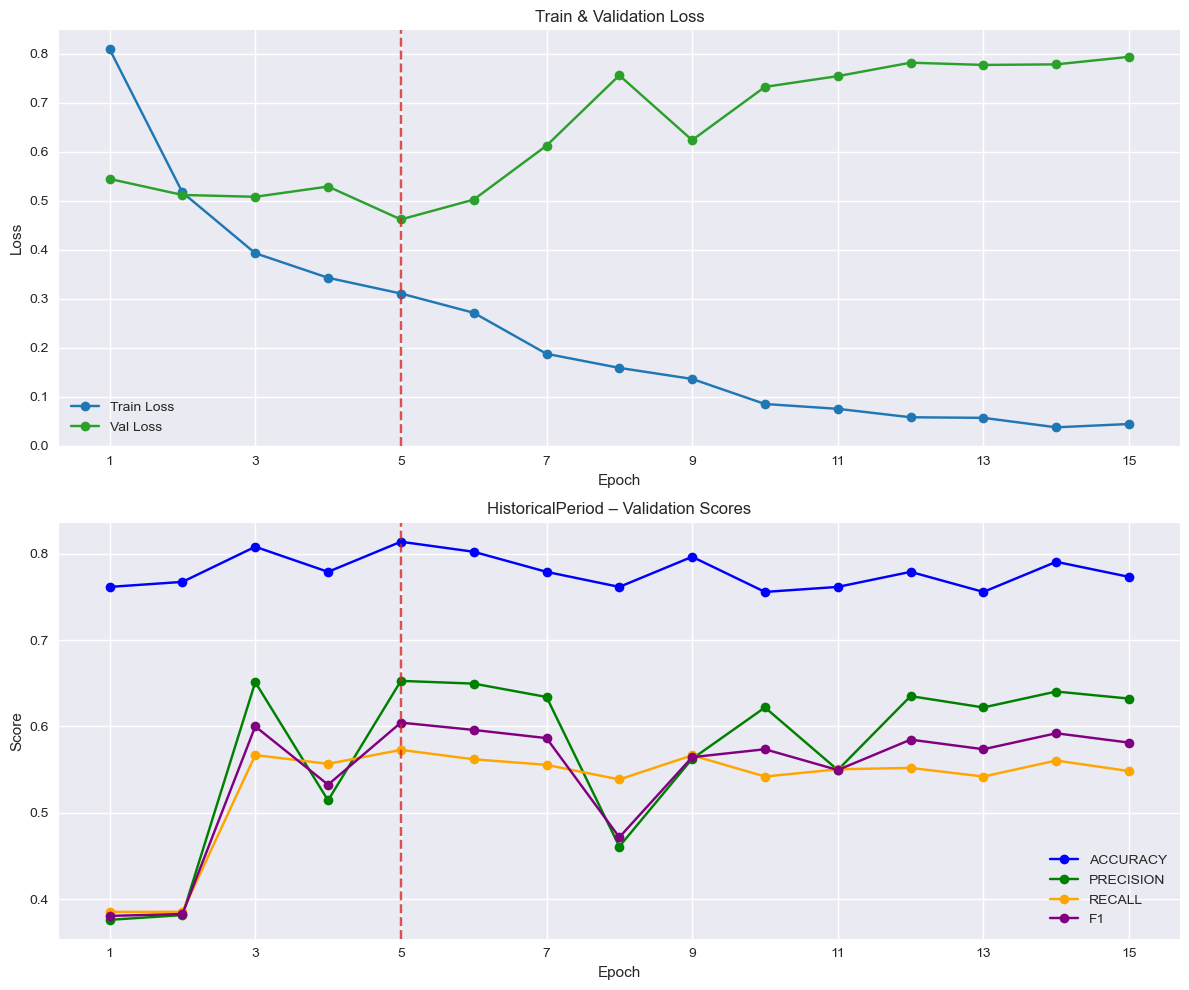

In [22]:
fts = ["tfidf", "vit"]
ft = " + ".join(fts)
params = best_params[ft]["params"]
pd.Series(params, name="value")

model = PotteryChronologyPredictor(
    [X_dim[_ft] for _ft in fts],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="periods"
)

model.summary()

# Train Model
model, history = train(
    model,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    lr=params["lr"],
)

plot_history(history, [target])

# Save Model
torch.save(model.state_dict(), get_model_path(path_models, "_".join(fts)))